In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets

In [69]:
import torchvision

torchvision.__version__

'0.20.1+cu124'

In [70]:
!pip show torchvision

Name: torchvision
Version: 0.20.1
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: /home/jax4zk/.local/lib/python3.11/site-packages
Requires: numpy, pillow, torch
Required-by: baukit, lpips, timm


# MNIST

In [48]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.1)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [49]:
def get_best_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# load model
state_dict = torch.load("mnist_state_dict.pt", map_location = get_best_device())
mnist_model = MNISTClassifier()
mnist_model.load_state_dict(state_dict)

/tmp/ipykernel_619297/2297830890.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("mnist_state_dict.pt", map_location = get_best_device())


<All keys matched successfully>

In [50]:
# define dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

dataset = datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)
loader = DataLoader(dataset, shuffle=True, batch_size=1)

tensor([8])


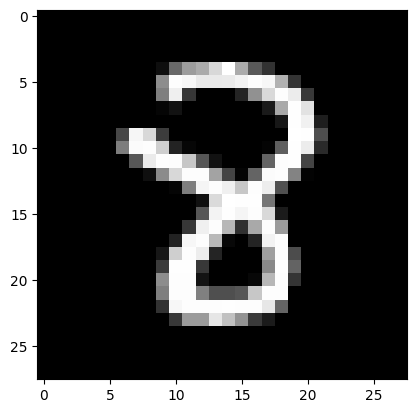

In [51]:
import matplotlib.pyplot as plt

def visualize_mnist_image(img):
    img = img.view(784)
    np_img = img.numpy()
    mat = np_img.reshape(28, 28)
    plt.imshow(mat, cmap='grey')

    
x,y = next(iter(loader))
visualize_mnist_image(x)
print(y)

In [57]:
def run_mnist_fgsm(model, x, y, epsilon=[0.1]):
    
    model.eval()
    device = next(model.parameters()).device
    
    x = x.view(-1, 784).detach()
    x= x.to(device)
    y = y.to(device)
    x.requires_grad = True
    
    out = model(x) 
    
    loss = F.cross_entropy(out, y)
    loss.backward()
    
    if not isinstance(epsilon, list):
        epsilon = [epsilon]
    
    num_epsilon = len(epsilon)
    epsilon = torch.tensor(epsilon) # len
    epsilon = epsilon.view(num_epsilon , -1)
    
    grad_sign = torch.where(x.grad > 0, 1, -1)
    mod_x = x + (grad_sign * epsilon)
    
    mod_x = mod_x.detach() # (num_epsilon, 784)
    diff_x = mod_x - x
    diff_x = diff_x.detach()
    
    
    probs = model(mod_x) # (num_epsilon, 1000)
    probs = torch.softmax(probs, dim=-1)
    row_indices = torch.arange(0, num_epsilon, device=device)
    probs = probs[row_indices, y]
    
    return mod_x, diff_x, probs

In [58]:
x,y = next(iter(loader))
mod_x, diff_x, probs = run_mnist_fgsm(mnist_model, x, y, [0.05, 0.1, 0.2, 0.3, 1000])
print(mod_x.shape)
print(diff_x.shape)
print(probs.shape)
print(probs)

torch.Size([5, 784])
torch.Size([5, 784])
torch.Size([5])
tensor([9.9998e-01, 9.9688e-01, 1.7977e-04, 1.2183e-07, 0.0000e+00],
       grad_fn=<IndexBackward0>)


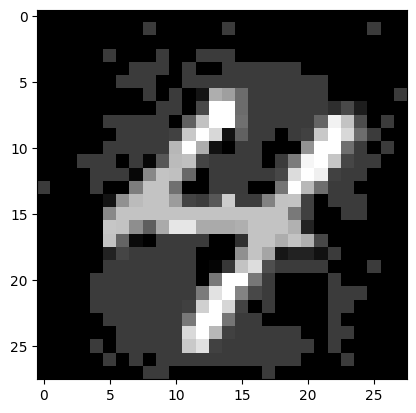

In [22]:
visualize_mnist_image(mod_x[3, :])

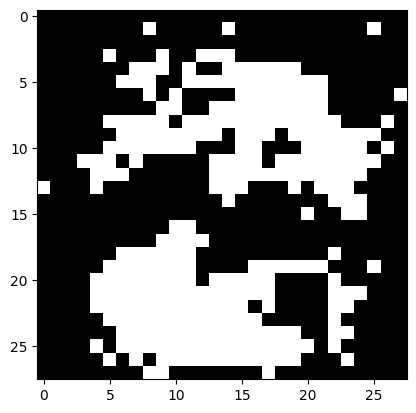

In [23]:
visualize_mnist_image(diff_x[3, :])

# ImageNet

In [24]:
import torchvision.models as models

imagenet_model = models.resnet50(pretrained=True)

best_device = get_best_device()
imagenet_model = imagenet_model.to(best_device)

num_parameters = sum([p.numel() for p in imagenet_model.parameters()])
print(f"Number of parameters in ResNet-50: {num_parameters / 1e6} M")

/home/jax4zk/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jax4zk/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Number of parameters in ResNet-50: 25.557032 M


In [93]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

imagenette = datasets.Imagenette(root='./imagenette/', split='train', size='full', transform = transform)

In [79]:
class_ids = {0: 0, 1: 482, 2: 497, 3: 566, 4: 569, 5: 571, 6: 574, 7: 701}



def run_imagenet_fgsm(model, x, y, epsilon=[0.1]):
    model.eval()
    
    device = next(model.parameters()).device
    
    y = class_ids[y]
    
    x = x.to(device)
    x.requires_grad = True
    y = torch.tensor([y], device=device)
    
    logits = model(x)
    
    loss = F.cross_entropy(logits, y)
    loss.backward()
    
    num_epsilon = len(epsilon)
    epsilon = torch.tensor(epsilon, device=device) # (num_epsilon, )
    epsilon = epsilon.view(num_epsilon, 1, 1, 1)
    
    grad = torch.where(x.grad > 0, 1, -1)
    
    print(grad.size())
    print(epsilon.size())
    
    x_mod = x + grad * epsilon
    x_diff = x_mod - x
    
    x_mod = x_mod.detach()
    x_diff = x_diff.detach()
    
    probs = model(x_mod) # (num_epsilon, 1000)
    probs = torch.softmax(probs, dim=-1)
    row_indices = torch.arange(0, num_epsilon, device=device)
    probs = probs[row_indices, y]
    
    return x_mod, x_diff, probs

In [80]:
x, y = next(iter(imagenette))

x_mod, x_diff, probs = run_imagenet_fgsm(imagenet_model, x, y, epsilon=[0.01, 0.1, 0.15, 0.2, 0.3, 0.5])
print(f"x_mod.size(): {x_mod.size()}")
print(f"x_diff.size(): {x_diff.size()}")
print(f"probs.size(): {probs.size()}")
print(probs)

torch.Size([1, 3, 375, 500])
torch.Size([6, 1, 1, 1])
x_mod.size(): torch.Size([6, 3, 375, 500])
x_diff.size(): torch.Size([6, 3, 375, 500])
probs.size(): torch.Size([6])
tensor([1.8792e-03, 1.9751e-04, 1.7752e-04, 1.9144e-04, 1.2482e-04, 9.8341e-05],
       device='cuda:0', grad_fn=<IndexBackward0>)


In [28]:
def visualize_imagenet_image(img):
    img = img.cpu().numpy()
    # print(img.shape)
    img = img.reshape(img.shape[1:])
    img = img.transpose(1, 2, 0)
    plt.axis("off")
    plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.5836544..3.14].


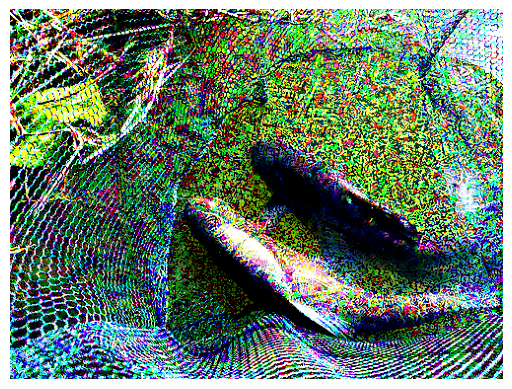

In [29]:
visualize_imagenet_image(x_mod)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


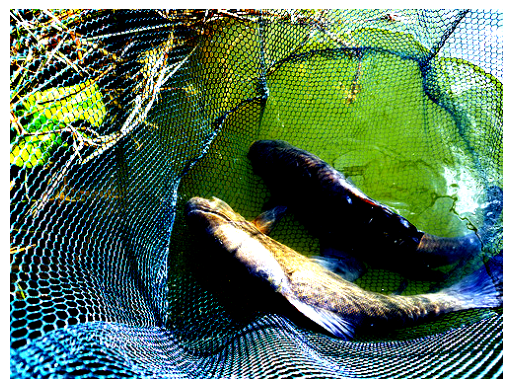

In [30]:
visualize_imagenet_image(x.unsqueeze(0))

In [31]:
x.size()

torch.Size([3, 375, 500])

In [32]:
x_mod.size()

torch.Size([1, 3, 375, 500])

In [36]:
def get_prob_of_class_imagenet(model, x, y):
    if x_mod.ndim != 4:
        x = x.unsqueeze(0)
        print(x.size())
    
    row_id
    
    logits = model

In [37]:
get_prob_of_class_imagenet(x_mod, y)

torch.Size([3, 375, 500])


In [96]:
my_iter = iter(imagenette)

loader = DataLoader(imagenette, shuffle=True)

In [100]:
x, y = next(iter(loader))
print(x.size(), y)
visualize_imagenet_image(x.unsqueeze(0))
print(y)

torch.Size([1, 3, 1035, 720]) tensor([9])


ValueError: axes don't match array

# Playing around with indexing

In [41]:
a = torch.tensor([[1,2,3], [4,5,6], [7,8,9]])
a[torch.tensor([1,2,2]), torch.tensor([2, 0, 2])]

tensor([6, 7, 9])

In [44]:
a[[0,1,2], [0]]

tensor([1, 4, 7])